In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import Ridge
from sklearn.metrics import accuracy_score, mean_squared_error, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import optuna
import pandas as pd
import seaborn as sns

model_random_forest = None
model_ridge = None
model_xgboost = None

### Random Forest (classificação) - Previsão de aprovação de alunos

In [29]:
df_rf = pd.read_csv('./datasets/original_treated.csv')

def prepare_data(dataframe: pd.DataFrame):
    cols_to_drop = [
        'status',
        'g2',
        'final_grade',
        'canceled_discipline',
        'skipped_discipline',
        'class_skips',
        'id',
        'student_id',
    ]

    df_clean = dataframe.drop(columns=cols_to_drop, errors='ignore')

    X = df_clean.drop(columns=['is_approved'])
    y = df_clean['is_approved']

    return X, y

X, y = prepare_data(df_rf)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def objective(trial: optuna.trial.Trial):
    # sugestões de hiperparâmetros do Optuna
    hiperparams = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 300),
        'max_depth': trial.suggest_int('max_depth', 2, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 10),
    }

    clf = RandomForestClassifier(
        **hiperparams,
        random_state=42,
        n_jobs=-1,
        class_weight='balanced'
    )

    clf.fit(X_train, y_train)
    preds = clf.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\n--- RESULTADOS ---")
print(f"Melhor Acurácia: {study.best_value:.4f}")
print("Melhores parâmetros:")
for key, value in study.best_params.items():
    print(f"\t- {key}: {value}")

[I 2025-12-01 00:42:36,539] A new study created in memory with name: no-name-d8a2d45d-751b-4ebc-94d7-1ff2df0ea625
[I 2025-12-01 00:42:37,519] Trial 0 finished with value: 0.9674913693901036 and parameters: {'n_estimators': 159, 'max_depth': 14, 'min_samples_split': 17, 'min_samples_leaf': 2}. Best is trial 0 with value: 0.9674913693901036.
[I 2025-12-01 00:42:37,666] Trial 1 finished with value: 0.9667721518987342 and parameters: {'n_estimators': 17, 'max_depth': 28, 'min_samples_split': 4, 'min_samples_leaf': 8}. Best is trial 0 with value: 0.9674913693901036.
[I 2025-12-01 00:42:38,906] Trial 2 finished with value: 0.9653337169159953 and parameters: {'n_estimators': 235, 'max_depth': 26, 'min_samples_split': 15, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.9674913693901036.
[I 2025-12-01 00:42:39,536] Trial 3 finished with value: 0.9664844649021864 and parameters: {'n_estimators': 113, 'max_depth': 27, 'min_samples_split': 18, 'min_samples_leaf': 7}. Best is trial 0 with va


--- RESULTADOS ---
Melhor Acurácia: 0.9708
Melhores parâmetros:
	- n_estimators: 31
	- max_depth: 25
	- min_samples_split: 6
	- min_samples_leaf: 1


C:\Users\Raisson\AppData\Local\Temp\ipykernel_18800\2788777273.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_importance, x='Importancia', y='Feature', palette='magma')


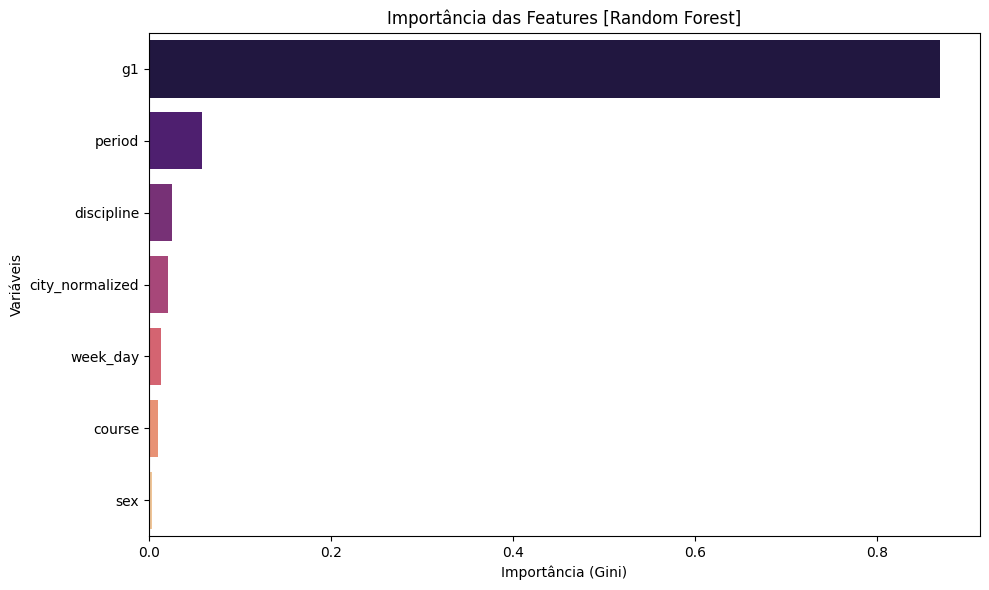

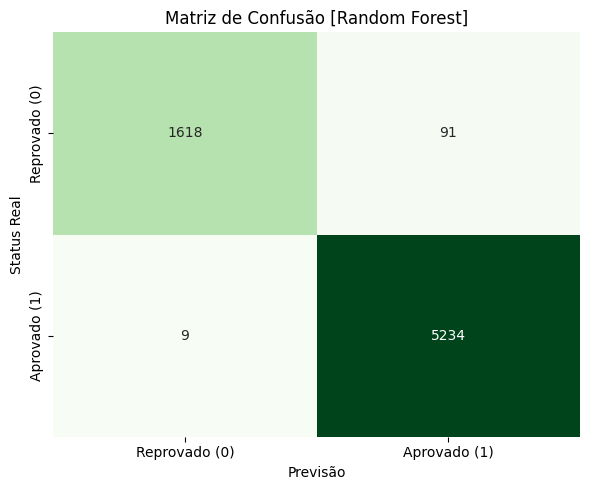

In [30]:
model_random_forest = RandomForestClassifier(**study.best_params, random_state=42)
model_random_forest.fit(X, y)

df_importance = pd.DataFrame({
    'Feature': X.columns,
    'Importancia': model_random_forest.feature_importances_,
}).sort_values(by='Importancia', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=df_importance, x='Importancia', y='Feature', palette='magma')
plt.title('Importância das Features [Random Forest]')
plt.xlabel('Importância (Gini)')
plt.ylabel('Variáveis')
plt.tight_layout()
plt.show()

y_pred = model_random_forest.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Greens',
    cbar=False,
    xticklabels=['Reprovado (0)', 'Aprovado (1)'],
    yticklabels=['Reprovado (0)', 'Aprovado (1)'],
)
plt.title('Matriz de Confusão [Random Forest]')
plt.xlabel('Previsão')
plt.ylabel('Status Real')
plt.tight_layout()
plt.show()

### Regressão Linear Múltipla (regressão) - Previsão da nota final

In [31]:
df_rlm = pd.read_csv('./datasets/original_treated.csv')

def prepare_regression_data(dataframe: pd.DataFrame):
    cols_to_drop = [
        'id',
        'student_id',
        'final_grade',
        'is_approved',
        'status',
        'g2',
        'canceled_discipline',
        'skipped_discipline',
        'class_skips',
    ]

    X = dataframe.drop(columns=cols_to_drop, errors='ignore')
    y = dataframe['final_grade']

    return X, y

X, y = prepare_regression_data(df_rlm)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

def objective(trial: optuna.trial.Trial):
    # sugestões de hiperparâmetros do Optuna
    hiperparams = {
        'alpha': trial.suggest_float('alpha', 0.01, 100.0, log=True),
        'solver': trial.suggest_categorical('solver', ['auto', 'svd', 'cholesky', 'lsqr']),
    }

    model = Ridge(**hiperparams, random_state=42)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return np.sqrt(mean_squared_error(y_test, preds))

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=50)

print("\n--- RESULTADOS ---")
print(f"Melhor RMSE (Erro Médio na Nota): {study.best_value:.4f}")
print("Melhores parâmetros:")
for key, value in study.best_params.items():
    print(f"\t- {key}: {value}")

model_ridge = Ridge(**study.best_params)
model_ridge.fit(X, y)

[I 2025-12-01 00:43:05,656] A new study created in memory with name: no-name-4ea9a556-2a5b-47c6-8d98-901ede257e8e
[I 2025-12-01 00:43:05,666] Trial 0 finished with value: 0.10038019720140942 and parameters: {'alpha': 1.780410622845918, 'solver': 'lsqr'}. Best is trial 0 with value: 0.10038019720140942.
[I 2025-12-01 00:43:05,678] Trial 1 finished with value: 0.1003806870433357 and parameters: {'alpha': 1.264521654773113, 'solver': 'lsqr'}. Best is trial 0 with value: 0.10038019720140942.
[I 2025-12-01 00:43:05,684] Trial 2 finished with value: 0.10037611258543733 and parameters: {'alpha': 8.928743472448643, 'solver': 'auto'}. Best is trial 2 with value: 0.10037611258543733.
[I 2025-12-01 00:43:05,694] Trial 3 finished with value: 0.10038182163367816 and parameters: {'alpha': 0.1387620490181312, 'solver': 'svd'}. Best is trial 2 with value: 0.10037611258543733.
[I 2025-12-01 00:43:05,700] Trial 4 finished with value: 0.1003758912004893 and parameters: {'alpha': 11.507882559657622, 'solv


--- RESULTADOS ---
Melhor RMSE (Erro Médio na Nota): 0.1004
Melhores parâmetros:
	- alpha: 11.507882559657622
	- solver: cholesky


,alpha,11.507882559657622
,fit_intercept,True
,copy_X,True
,max_iter,None
,tol,0.0001
,solver,'cholesky'
,positive,False
,random_state,None


### XGBoost (classificação) - Previsão de aprovação de alunos

In [32]:
df_rf = pd.read_csv('./datasets/original_treated.csv')

def prepare_data_xgb(dataframe: pd.DataFrame):
    cols_to_drop = [
        'status',
        'g2',
        'final_grade',
        'canceled_discipline', 
        'skipped_discipline',
        'class_skips', 
        'id',
        'student_id',
        'is_approved',
    ]

    X = dataframe.drop(columns=cols_to_drop, errors='ignore')
    y = dataframe['is_approved']

    return X, y

X, y = prepare_data_xgb(df_rf)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

def objective(trial: optuna.trial.Trial):
    # sugestões de hiperparâmetros do Optuna
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 50, 500),
        'max_depth': trial.suggest_int('max_depth', 3, 10),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.3, log=True),
        'random_state': 42,
        'n_jobs': -1,
    }

    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    return accuracy_score(y_test, preds)

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

print("\n--- RESULTADOS ---")
print(f"Melhor Acurácia: {study.best_value:.4f}")
print("Melhores parâmetros:")
for key, value in study.best_params.items():
    print(f"\t- {key}: {value}")

[I 2025-12-01 00:43:06,227] A new study created in memory with name: no-name-6a6b0d89-1051-4d76-baf5-09412ba76239
[I 2025-12-01 00:43:06,700] Trial 0 finished with value: 0.9707997698504027 and parameters: {'n_estimators': 115, 'max_depth': 10, 'learning_rate': 0.041422601585402855}. Best is trial 0 with value: 0.9707997698504027.
[I 2025-12-01 00:43:07,082] Trial 1 finished with value: 0.9686421173762946 and parameters: {'n_estimators': 108, 'max_depth': 10, 'learning_rate': 0.18252143728644427}. Best is trial 0 with value: 0.9707997698504027.
[I 2025-12-01 00:43:07,915] Trial 2 finished with value: 0.9710874568469505 and parameters: {'n_estimators': 358, 'max_depth': 7, 'learning_rate': 0.017170164355996782}. Best is trial 2 with value: 0.9710874568469505.
[I 2025-12-01 00:43:08,325] Trial 3 finished with value: 0.9710874568469505 and parameters: {'n_estimators': 100, 'max_depth': 10, 'learning_rate': 0.056318078780932826}. Best is trial 2 with value: 0.9710874568469505.
[I 2025-12-0


--- RESULTADOS ---
Melhor Acurácia: 0.9727
Melhores parâmetros:
	- n_estimators: 294
	- max_depth: 5
	- learning_rate: 0.06068086811993707


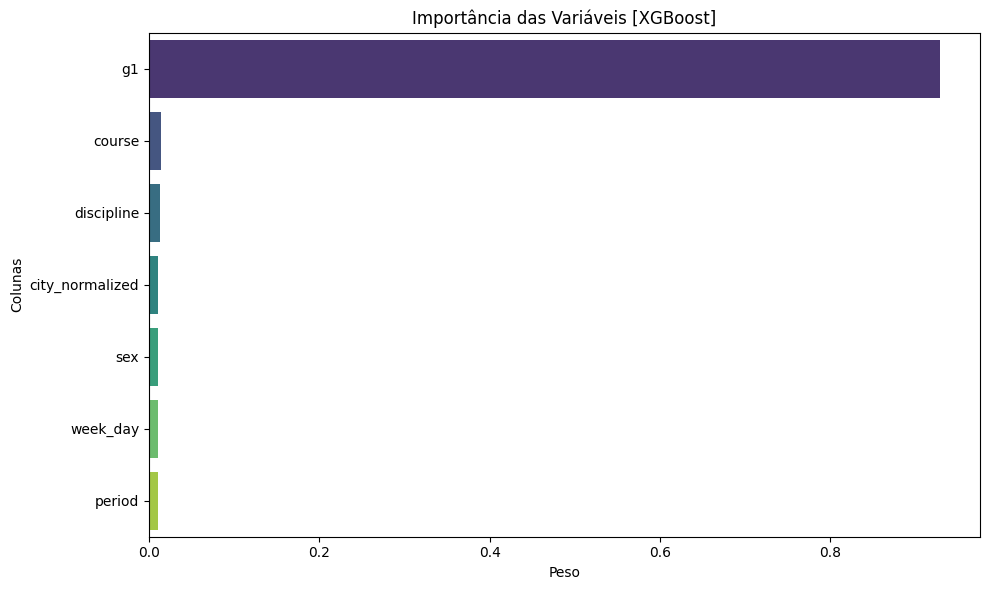

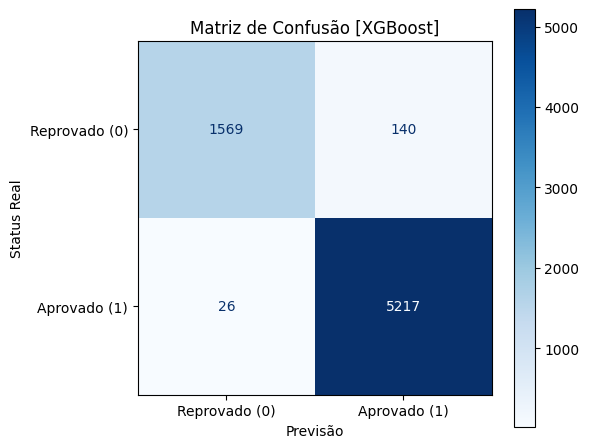

In [33]:
model_xgboost = XGBClassifier(**study.best_params, random_state=42)
model_xgboost.fit(X, y)
preds_val = model_xgboost.predict(X_test)

feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model_xgboost.feature_importances_,
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importances, hue='Feature', palette='viridis', legend=False)
plt.title('Importância das Variáveis [XGBoost]')
plt.xlabel('Peso')
plt.ylabel('Colunas')
plt.tight_layout()
plt.show()

cm = confusion_matrix(y_test, preds_val)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Reprovado (0)', 'Aprovado (1)'])

fig, ax = plt.subplots(figsize=(6, 5))
disp.plot(cmap='Blues', ax=ax, values_format='d')
plt.title('Matriz de Confusão [XGBoost]')
plt.xlabel('Previsão')
plt.ylabel('Status Real')
plt.tight_layout()
plt.show()